In [1]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from fastai.callbacks import LossMetrics
from pathlib import Path

In [2]:
#export
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from facelib.face_dataset_unlabeled import create_cropped_data, config

In [5]:
df, filename2label = create_cropped_data()
df.head()

,image_path,valid,dataset
0,../data/face/unlabeled_cropped_images/sof_1.jpg,False,unlabeled_cropped
1,../data/face/unlabeled_cropped_images/sof_724.jpg,False,unlabeled_cropped
2,../data/face/unlabeled_cropped_images/sof_404.jpg,False,unlabeled_cropped
3,../data/face/unlabeled_cropped_images/sof_1277...,False,unlabeled_cropped
4,../data/face/unlabeled_cropped_images/sof_2491...,False,unlabeled_cropped


In [6]:
get_random_color = lambda: tuple(np.random.choice(range(256), size=3))
pretty_colors = [(255, 0, 0), (255, 63, 0), (255, 127, 0), (255, 191, 0), (255, 255, 0), (191, 255, 0), (127, 255, 0), (63, 255, 0), (0, 255, 0), (0, 255, 63), (0, 255, 127), (0, 255, 191), (0, 255, 255), (0, 191, 255), (0, 127, 255), (0, 63, 255), (0, 0, 255), (63, 0, 255), (127, 0, 255), (191, 0, 255), (255, 0, 255), (255, 0, 191), (255, 0, 127), (255, 0, 63)]
# fpoint_colors = (pretty_colors * 3)[:68]
fpoint_colors = [get_random_color() for i in range(68)]
# fpoint_colors = [(255,0,0) for i in range(68)]

In [7]:
rgb2hex = lambda r,g,b: '#%02x%02x%02x' % (r,g,b)
fpoint_colors = list(map(lambda x: rgb2hex(*x), fpoint_colors))

# Databunch

In [8]:
binary_predictions = [
('BackgroundUniformity', 0.5),
('BlinkConfidence', 0.6),
('Contrast', 0.8),
('DarkGlassesConfidence', 0.5),
('DetectionConfidence', 0.65),
('ExpressionConfidence', 0.6),
('FaceDarknessConfidence', 0.9),
('GlassesConfidence', 0.4),
('GlassesReflectionConfidence', 0.99),
('GrayscaleDensity', 0.8),
('LookingAwayConfidence', 0.65),
('MouthOpenConfidence', 0.6),
('Noise', 0.8),
('PixelationConfidence', 0.99),
('Quality', 0.9),
('RedEyeConfidence', 0.99),
('Saturation', 1),
('Sharpness', 0.75),
('SkinReflectionConfidence', 0.4),
('UnnaturalSkinToneConfidence', 0.55),
('WashedOutConfidence', 0.95)
]

float_predictions = [
('Yaw', 0.05, 8.47),
('Roll', -1.01, 6.59),
('Pitch', -8.44, 6.09),
]

float_names = list(map(lambda x:x[0], float_predictions))
bin_names = list(map(lambda x:x[0], binary_predictions))

float_stats = torch.tensor([[mean, std] for name, mean, std in float_predictions])
bin_stats = torch.tensor([[mean, 1] for name, mean in binary_predictions])

In [9]:
def path2bb(path):
    fn = path.split(os.path.sep)[-1]
    label = filename2label[fn]
    fpoints = tensor(label['FeaturePoints'])
    scalars = label['Scalars']
    c = lambda x: torch.clamp(x, 0, 1)
#     bin_values = [c(scalars[n] - (mean-0.5)) for n, (mean,std) in zip(bin_names, bin_stats)] # normalized to have mean of 0.5
    bin_values = [scalars[n] for n, (mean,std) in zip(bin_names, bin_stats)]
    float_values = [scalars[n] for n in float_names]
    other_data = (tensor(bin_values), tensor(float_values))
    return fpoints, other_data

In [10]:
class MyImagePoints(ImagePoints):
    "Support applying transforms to a `flow` of points."
    def __init__(self, flow, scale=True, y_first=True, other_data=None):
        super().__init__(flow, scale, y_first)
        self.other_data = other_data

    def clone(self):
        "Mimic the behavior of torch.clone for `ImagePoints` objects."
        return self.__class__(FlowField(self.size, self.flow.flow.clone()), scale=False, y_first=False, other_data=self.other_data)

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, **kwargs):
        "Show the `ImagePoints` on `ax`."
        if ax is None: _,ax = plt.subplots(figsize=figsize)
        pnt = scale_flow(FlowField(self.size, self.data), to_unit=False).flow.flip(1)
        params = {'s': 20, 'marker': '.', **kwargs}
        for (y,x),color in zip(pnt, fpoint_colors):
            ax.scatter(y, x, color=color, **params)
        if hide_axis: ax.axis('off')
        bin_vals, float_vals = map(list, self.other_data)
        preds, values = bin_names + float_names, bin_vals + float_vals
        values = map(lambda v: str(int(v*100)/100), values)
        text = '\n'.join([ k+'  '+str(v) for k,v in zip(preds,values) ])
        ax.set_title(text)

In [11]:
class PointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList): self.c = len(ds.items[0].reshape(-1))
    def process(self, ds:ItemList):  ds.c = self.c

In [12]:
def _get_size(xs,i):
    size = xs.sizes.get(i,None)
    if size is None: # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

class MyPointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = PointsProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = MSELossFlat()

    def get(self, i):
        fpoints, other_data = super().get(i)
        return MyImagePoints(FlowField(_get_size(self.x,i), fpoints), scale=True, other_data=other_data)

    def analyze_pred(self, pred, thresh:float=0.5): return [pred[0].view(-1,2)] + pred[1:]
    def reconstruct(self, t, x):
        fpts, *other_data = t
        return MyImagePoints(FlowField(x.size, fpts), scale=False, other_data=other_data)

In [13]:
class MyPointsItemList(ImageList):
    "`ItemList` for `Image` to `ImagePoints` tasks."
    _label_cls,_square_show_res = MyPointsLabelList,False

In [14]:
def create_src():
    return (MyPointsItemList.from_df(df, path='../models', cols='image_path')
#                       .split_from_df('valid')
                      .split_by_rand_pct(0.1)
                      .label_from_func(path2bb)
            )

In [15]:
src = create_src()
src

LabelLists;

Train: LabelList (77517 items)
x: MyPointsItemList
Image (3, 181, 162),Image (3, 345, 330),Image (3, 192, 183),Image (3, 278, 296),Image (3, 170, 148)
y: MyPointsLabelList
MyImagePoints (181, 162),MyImagePoints (345, 330),MyImagePoints (192, 183),MyImagePoints (278, 296),MyImagePoints (170, 148)
Path: ../models;

Valid: LabelList (8613 items)
x: MyPointsItemList
Image (3, 212, 202),Image (3, 260, 246),Image (3, 146, 144),Image (3, 197, 218),Image (3, 255, 238)
y: MyPointsLabelList
MyImagePoints (212, 202),MyImagePoints (260, 246),MyImagePoints (146, 144),MyImagePoints (197, 218),MyImagePoints (255, 238)
Path: ../models;

Test: None

In [16]:
#export
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0):
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1].data[1]) for s in samples])
    bin_true = torch.zeros(len(samples), len(bin_names))
    float_true = torch.zeros(len(samples), len(float_names))
    fpoints_true = torch.zeros(len(samples), 68,2)
    imgs = []
    for i, (image, point_obj) in enumerate(samples):
        c,h,w = image.shape
        fpoints = point_obj.data
        bin_values, float_values = point_obj.other_data
        imgs.append(image.data[None])
        bin_true[i] = bin_values
        float_true[i] = float_values
        fpoints_true[i] = fpoints #.view(68*2)
    images = torch.cat(imgs,0)
    return images, (fpoints_true, bin_true, float_true)

In [17]:
train_transforms = [
    rotate(degrees=(-45, 45), p=0.5),
    symmetric_warp(magnitude=(-0.2, 0.2), p=0.5),
    rand_zoom(scale=(0.6,1.8), p=0.6),
    brightness(change=(0.3, 0.7), p=0.5),
    contrast(scale=(0.7,1.3), p=0.5),
    rand_crop(padding_mode='zeros')
]
valid_transforms = [
]

custom_transforms = (train_transforms,valid_transforms)

In [18]:
def create_data(src, size, bs=4, transforms=None, padding='zeros'): # 'zeros'/'border'
    return (src.transform(transforms, size=size, padding_mode=padding, tfm_y=True, remove_out=False)
                        .databunch(bs=bs, collate_fn=bb_pad_collate)
#                         .normalize(imagenet_stats) # (normalized in model)
    )

In [19]:
data = create_data(src, 224)
data

ImageDataBunch;

Train: LabelList (77517 items)
x: MyPointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MyPointsLabelList
MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224)
Path: ../models;

Valid: LabelList (8613 items)
x: MyPointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MyPointsLabelList
MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224),MyImagePoints (224, 224)
Path: ../models;

Test: None

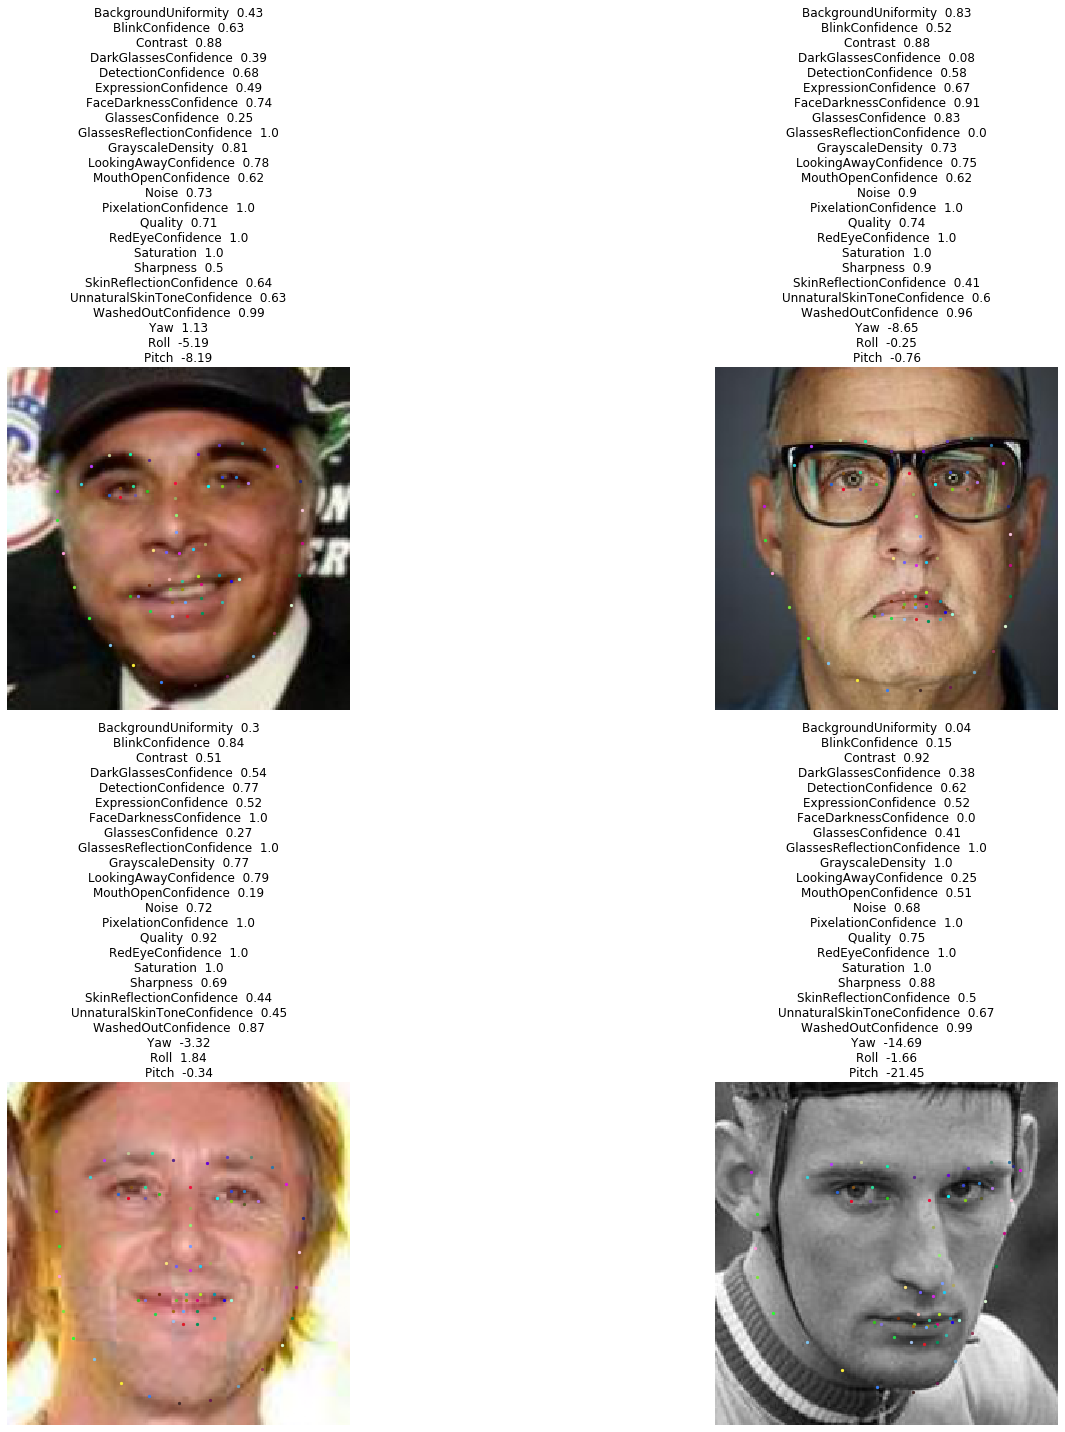

In [20]:
data.show_batch(figsize=(20,20))

In [21]:
def freeze_layers(learner, layers):
    "Freeze layers for specific layer groups."
    for i, g in enumerate(learner.layer_groups):
        if i in layers: 
            for l in g:
                if not learner.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        else: requires_grad(g, True)
    learner.create_opt(defaults.lr)
    
def show_results(learner, *args, rows=1, figsize=(20,20), **kwargs):
    learner.show_results(*args, **kwargs, rows=rows, figsize=(figsize[0],figsize[1]*rows))

In [22]:
def save_torch_inference(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_inference(model, path, device=torch.device('cpu')):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

# Model

In [23]:
from torchvision import models as torch_models

In [24]:
x = torch.randn(2,3,128,128)
nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])(x).shape

torch.Size([2, 512, 4, 4])

In [25]:
#export
imagenet_stats = torch.tensor(([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class FaceModel(nn.Module):
    def __init__(self, num_bins, num_floats, float_stats, num_fpts=68*2, d_model=512, poolsize=(8,8)):
        # float_stats.shape = [num_floats, 2], where 2 = (mean, std)
        super().__init__()
        self.means = imagenet_stats[0].reshape(1,3,1,1) # [R,G,B]
        self.stds = imagenet_stats[1].reshape(1,3,1,1) # [R,G,B]
        
        assert len(float_stats) == num_floats
        self.float_means = float_stats[:,0].reshape(1,-1)
        self.float_stds = float_stats[:,1].reshape(1,-1)

        resnet = torch_models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        h,w = poolsize
        self.res_head = nn.Sequential(nn.BatchNorm2d(512), nn.AdaptiveAvgPool2d([h,w]), Flatten(),
                                      nn.Linear(h*w*512, d_model), nn.ReLU(), 
                                      nn.BatchNorm1d(d_model), nn.Dropout(0.3))
                                   
        self.W_fpts = nn.Linear(d_model, num_fpts)
        self.W_bin = nn.Linear(d_model+num_fpts+num_floats, num_bins)
        self.W_float = nn.Linear(d_model+num_fpts, num_floats)
        

    def forward(self, x_orig):
        b,c,h,w = x_orig.shape
        x = x_orig
        x = (x - self.means.to(x.device)) / self.stds.to(x.device) # normalize
        
        o = self.resnet(x) # [b,512,h',w']
        o = self.res_head(o)
        
        fpts = nn.Tanh()(self.W_fpts(o))*2 # [b,68*2]
        floats = nn.Tanh()(self.W_float( torch.cat([o,fpts], dim=1) ))*3
        bins = nn.Sigmoid()(self.W_bin( torch.cat([o,fpts,floats], dim=1) ))
        
        
        floats = (floats * self.float_stds.to(floats.device)) + self.float_means.to(floats.device)
        return fpts.view(b,68,2), bins, floats

In [26]:
fpts, bins, floats = FaceModel(len(bin_names), len(float_names), float_stats)(torch.zeros(2,3,224,224))
fpts.shape, bins.shape, floats.shape

(torch.Size([2, 68, 2]), torch.Size([2, 21]), torch.Size([2, 3]))

In [53]:
def create_learner(*args, **kwargs):
    learner = Learner(*args, **kwargs)
    list_layers = [
        learner.model.resnet,
        learner.model.res_head,
        learner.model.W_fpts,
        learner.model.W_bin,
        learner.model.W_float,
    ]
    learner.split(list_layers)
    print('Learner split in',len(learner.layer_groups),'groups')
    return learner

In [54]:
class SigmaL1SmoothLoss(nn.Module):
    def __init__(self, lambd=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambd = lambd
    
    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(reg_diff <= .1, 5*reg_diff**2, reg_diff - .05)
        return reg_loss.mean()

In [55]:
class ClipedSmoothL1Loss(nn.Module):
    def __init__(self, eps=1e-1):
        super().__init__()
        self.e = eps
        
    def forward(self, output, target):
        loss = nn.SmoothL1Loss(reduction='none').forward(output, target)
        return torch.clamp(loss, -self.e, self.e).mean()

In [56]:
class CustomLoss(nn.Module):
    def __init__(self, distance_loss_func, loss_weights):
        super().__init__()
        self.loss_func, self.loss_weights = distance_loss_func, loss_weights
        self.float_offset = 8*3
        self.metric_names = ['Ldist', 'Lspatial', 'Lbin_BCE', 'Lbin_MSE', 'Lfloat']

    def _dist_loss(self, y_pred, y_true):
        loss = self.loss_func(y_pred, y_true)
#         if loss > 1: print(y_pred, y_true)
        return loss
    
    def _spatial_loss(self, y_pred, y_true):
        b,p,c = y_pred.shape
        y_pred = y_pred.view(b,1,p,c) - y_pred.view(b,p,1,c)
        y_true = y_true.view(b,1,p,c) - y_true.view(b,p,1,c)
        return self.loss_func(y_pred.view(b,-1), y_true.view(b,-1))
    
    def _bin_loss(self, y_pred, y_soft): # y_true = y_soft
        y_hard = torch.zeros_like(y_soft)
        y_hard[ y_soft > 0.5 ] = 1
        loss_hard = nn.BCELoss(reduction='mean')(y_pred, y_hard)
#         for i in range(y_pred.shape[1]):
#             loss_hard += nn.KLDivLoss(reduction='batchmean')(y_pred[:,i][:,None], y_soft[:,i][:,None])
#         loss_hard = loss_hard / y_pred.shape[1]
#         loss_hard = tensor(0.).to(y_pred.device)
        loss_soft = nn.MSELoss(reduction='mean')(y_pred, y_soft)
        return loss_hard*0.1, loss_soft
    
    def _float_loss(self, y_pred, y_true):
        return nn.SmoothL1Loss(reduction='mean')(y_pred, y_true)
    
    def forward(self, nn_output, fpts_true, bin_true, float_true, *args, **kwargs):
        fpts_pred, bin_pred, float_pred = nn_output
        float_pred, float_true = map(lambda x:x/self.float_offset, [float_pred, float_true])
        self.metrics = tensor([0.]*len(self.metric_names))
        Ldist = self._dist_loss(fpts_pred, fpts_true)
        Lspatial = self._spatial_loss(fpts_pred, fpts_true)
        Lbin_hard, Lbin_soft = self._bin_loss(bin_pred, bin_true)
        Lfloat = self._float_loss(float_pred, float_true)
        losses = [l*w for l,w in zip([Ldist, Lspatial, Lbin_hard, Lbin_soft, Lfloat], self.loss_weights)]
        self.metrics[:len(losses)] = tensor(losses)
        self.metrics = dict(zip(self.metric_names, self.metrics))
        return sum(losses)

In [57]:
class CustomLossBinVisual(CustomLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.origin_len = len(self.metric_names)
        self.metric_names = self.metric_names + list(map(lambda n:'M'+n[:4], bin_names))
    
    def _bin_loss(self, y_pred, y_soft):
        loss = nn.L1Loss(reduction='none')(y_pred, y_soft)
        for i in range(loss.shape[1]):
            self.metrics[self.origin_len+i] = tensor(int(1000*loss[:,i].mean())/1000)
        return super()._bin_loss(y_pred, y_soft)

In [58]:
from fastai.callbacks import LossMetrics

class AddLossMetrics(LossMetrics):
    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0) # CHANGED
        for name in filter(lambda n: (n.startswith('L') or n.startswith('M')), self.names):
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        self.nums += bs

# Learner

In [59]:
def fit_model(src, model, epochs, lr, size, bs=64, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1, transforms=None):
    loss = CustomLossBinVisual(ClipedSmoothL1Loss(eps), loss_weights)
    data = create_data(src, size, bs=64, transforms=transforms)
    learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
    freeze_layers(learner, frozen_layers)
    learner.fit_one_cycle(epochs, lr)

In [60]:
model = FaceModel(len(bin_names), len(float_names), float_stats)

In [61]:
size = 224

In [62]:
loss = CustomLossBinVisual(ClipedSmoothL1Loss(1e-1), [1]*5)
data = create_data(src, size, bs=64, transforms=None)
learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
freeze_layers(learner, [])

Learner split in 5 groups


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


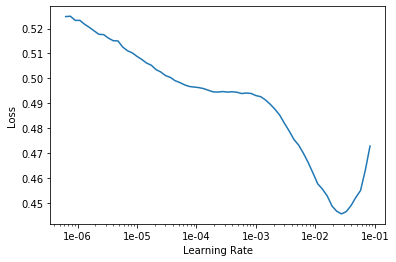

In [63]:
learner.lr_find()
learner.recorder.plot(skip_end=25)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.067480,0.067035,0.001824,0.001838,0.037849,0.018403,0.007121,0.141935,0.115262,0.092410,0.073967,0.081312,0.127790,0.068012,0.132150,0.132150,0.094790,0.131018,0.154518,0.102753,0.030016,0.120797,0.056584,0.013968,0.092733,0.069014,0.065356,0.060959,02:51


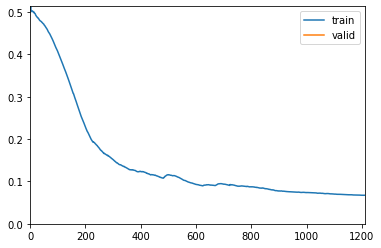

In [64]:
fit_model(src, model, epochs=1, lr=1e-3, size=size, bs=16, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.060052,0.050950,0.000701,0.000863,0.029916,0.016183,0.003287,0.134980,0.108192,0.088513,0.072644,0.072509,0.116045,0.066596,0.125006,0.125006,0.096976,0.125299,0.146086,0.096701,0.029076,0.112314,0.056670,0.012867,0.094283,0.081525,0.056582,0.059518,02:53
1,0.049499,0.044537,0.000429,0.000560,0.028466,0.012780,0.002303,0.124522,0.095885,0.075406,0.062983,0.069942,0.100998,0.059577,0.102155,0.102155,0.084527,0.122318,0.096941,0.090852,0.030623,0.110155,0.058344,0.012867,0.075566,0.055127,0.069284,0.057298,02:54


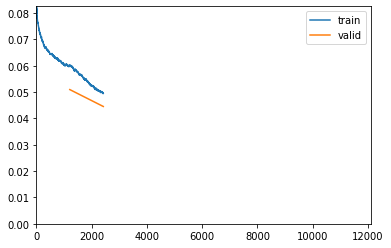

In [ ]:
fit_model(src, model, epochs=10, lr=1e-4, size=size, bs=16, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
fit_model(src, model, epochs=100, lr=1e-4, size=size, bs=16, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [52]:
save_torch_inference(learner.model, '../server/model.pth')

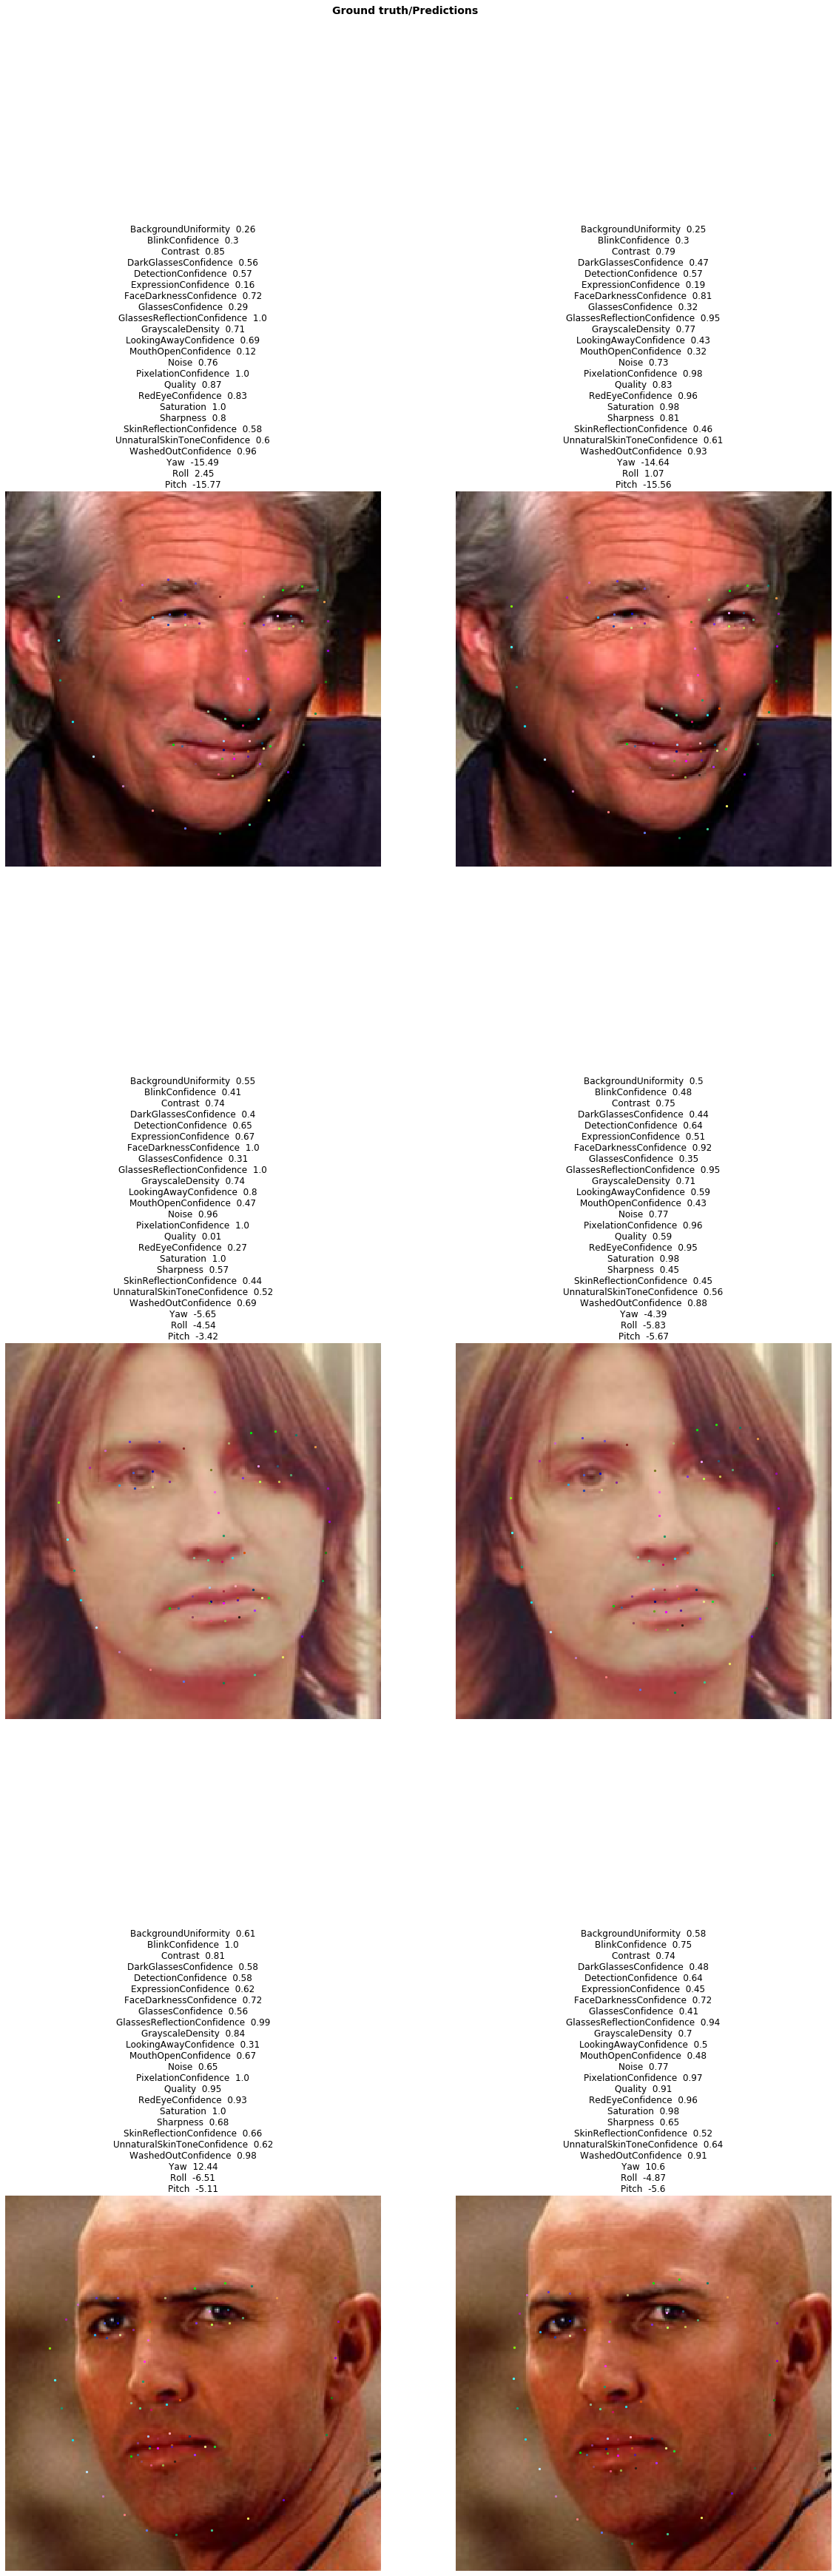

In [39]:
show_results(learner, DatasetType.Train, rows=3)

In [ ]:
fit_model(src, model, epochs=100, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [ ]:
save_torch_inference(learner.model, '../server/model.pth')

In [1]:
fit_model(src, model, epochs=100, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[2,4], loss_weights=[0,0,0,1,0], eps=1e-1)

NameError: name 'fit_model' is not defined

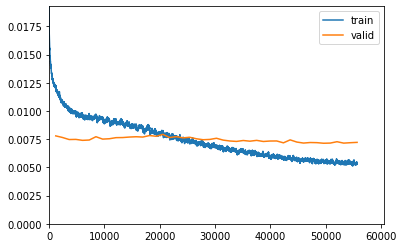

In [ ]:
fit_model(src, model, epochs=50, lr=1e-4, size=size, bs=8, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.014026,0.012290,0.001300,0.001880,0.000000,0.007066,0.002044,0.108438,0.077190,0.035532,0.046328,0.032643,0.070657,0.026921,0.083119,0.083119,0.044648,0.081823,0.066536,0.049458,0.036256,0.085868,0.039865,0.015521,0.047131,0.037919,0.023686,0.048203,02:50


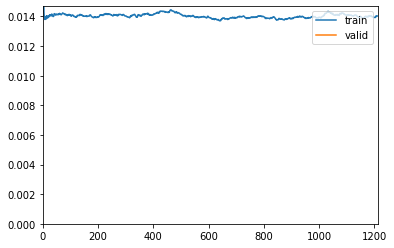

In [48]:
fit_model(src, model, epochs=1, lr=1e-8, size=size, bs=8, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

In [43]:
fit_model(src, model, epochs=50, lr=1e-4, size=size, bs=8, transforms=custom_transforms, frozen_layers=[0,4], loss_weights=[1,1,1,1,1], eps=1e-1)

In [67]:
save_torch_inference(learner.model, '../server/model.pth')

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.011430,0.009245,0.000285,0.000411,0.000000,0.007112,0.001437,0.109264,0.082527,0.037748,0.048426,0.035362,0.065772,0.039664,0.078922,0.078922,0.051737,0.087981,0.066152,0.051209,0.034003,0.101695,0.042937,0.015367,0.056467,0.045328,0.025691,0.046926,02:53
1,0.011913,0.009247,0.000288,0.000410,0.000000,0.007075,0.001473,0.108978,0.079190,0.038265,0.050420,0.035346,0.065612,0.036967,0.089579,0.089579,0.049528,0.087914,0.066393,0.053295,0.035386,0.102029,0.040606,0.015449,0.059462,0.041379,0.022220,0.047273,02:54
2,0.010791,0.009055,0.000282,0.000399,0.000000,0.006866,0.001509,0.107811,0.082057,0.037188,0.046307,0.033946,0.076137,0.038442,0.078963,0.078963,0.048760,0.087244,0.062519,0.050984,0.033594,0.090428,0.038548,0.014931,0.057237,0.037268,0.021015,0.046639,02:53
3,0.009836,0.008025,0.000245,0.000345,0.000000,0.006286,0.001149,0.105374,0.075625,0.034928,0.043979,0.033798,0.061861,0.036905,0.076078,0.076078,0.046899,0.083855,0.061372,0.047772,0.033289,0.089728,0.038612,0.012579,0.052702,0.037229,0.019085,0.045845,02:54


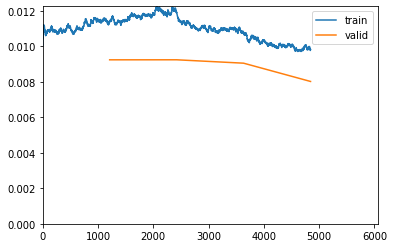

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [68]:
fit_model(src, model, epochs=5, lr=1e-4, size=size, bs=64, transforms=None, frozen_layers=[], loss_weights=[1,1,1,1,1], eps=1e-1)

epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.122127,0.065094,0.019324,0.035288,0.000000,0.007654,0.002828,0.110811,0.083603,0.048486,0.051503,0.038029,0.074966,0.054525,0.089622,0.089622,0.055924,0.089869,0.074679,0.052765,0.032320,0.092169,0.044067,0.015421,0.059755,0.056069,0.029728,0.047330,02:54
1,0.037785,0.064807,0.019267,0.035241,0.000000,0.007758,0.002541,0.112474,0.085942,0.046080,0.052385,0.038330,0.076805,0.047746,0.093032,0.093032,0.054820,0.090719,0.076998,0.052986,0.034434,0.093281,0.042337,0.016250,0.057191,0.053444,0.028220,0.047961,02:54
2,0.034262,0.065175,0.019292,0.035304,0.000000,0.007823,0.002756,0.112183,0.084511,0.048777,0.050737,0.038557,0.076731,0.047935,0.102008,0.102008,0.056183,0.089863,0.077812,0.054944,0.034613,0.100032,0.043620,0.016388,0.058198,0.051520,0.029080,0.048193,02:54
3,0.049115,0.064611,0.019246,0.035239,0.000000,0.007571,0.002555,0.111328,0.084765,0.044372,0.052600,0.038368,0.075143,0.044107,0.084531,0.084531,0.052901,0.088212,0.076196,0.052543,0.033669,0.096290,0.043210,0.015696,0.055469,0.046491,0.027443,0.050358,02:54
4,0.062053,0.064123,0.019329,0.035334,0.000000,0.007385,0.002075,0.110775,0.087242,0.044897,0.049854,0.037795,0.072519,0.044185,0.083491,0.083491,0.056673,0.087897,0.073044,0.051336,0.033156,0.093147,0.038179,0.015146,0.056192,0.050953,0.026097,0.047388,02:54
5,0.031184,0.063623,0.019153,0.035155,0.000000,0.007051,0.002264,0.109219,0.080902,0.043352,0.049340,0.037704,0.070607,0.042818,0.096841,0.096841,0.052784,0.086844,0.071062,0.049917,0.032369,0.093984,0.044560,0.015195,0.053188,0.046168,0.025235,0.046406,02:54
6,0.096799,0.063289,0.019329,0.035353,0.000000,0.006812,0.001796,0.107015,0.081265,0.041789,0.046972,0.036758,0.068806,0.042501,0.085964,0.085964,0.051373,0.085398,0.067429,0.049559,0.032268,0.090750,0.038979,0.013463,0.051916,0.049431,0.025558,0.046084,02:54
7,0.024363,0.062514,0.019144,0.035131,0.000000,0.006578,0.001661,0.106101,0.078632,0.042917,0.046943,0.036311,0.068109,0.040398,0.083090,0.083090,0.050734,0.084819,0.066799,0.048257,0.032800,0.089184,0.037834,0.014005,0.051017,0.045526,0.024261,0.045601,02:54
8,0.087082,0.062999,0.019392,0.035465,0.000000,0.006524,0.001619,0.105691,0.077763,0.041279,0.046063,0.036174,0.067575,0.040620,0.084472,0.084472,0.050136,0.084114,0.066179,0.048101,0.033127,0.088160,0.037187,0.014374,0.050634,0.044982,0.023644,0.045857,02:54
9,0.105352,0.062244,0.019111,0.035105,0.000000,0.006457,0.001571,0.105580,0.077372,0.041516,0.045765,0.036047,0.067449,0.039888,0.083215,0.083215,0.050388,0.084125,0.065725,0.047585,0.032599,0.088487,0.037690,0.013953,0.050671,0.044048,0.023496,0.045251,02:54


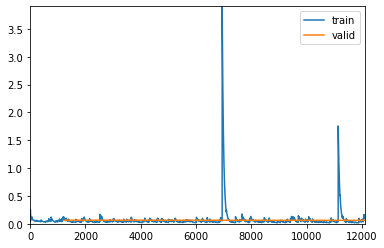

In [44]:
learner.fit_one_cycle(10, 1e-4)

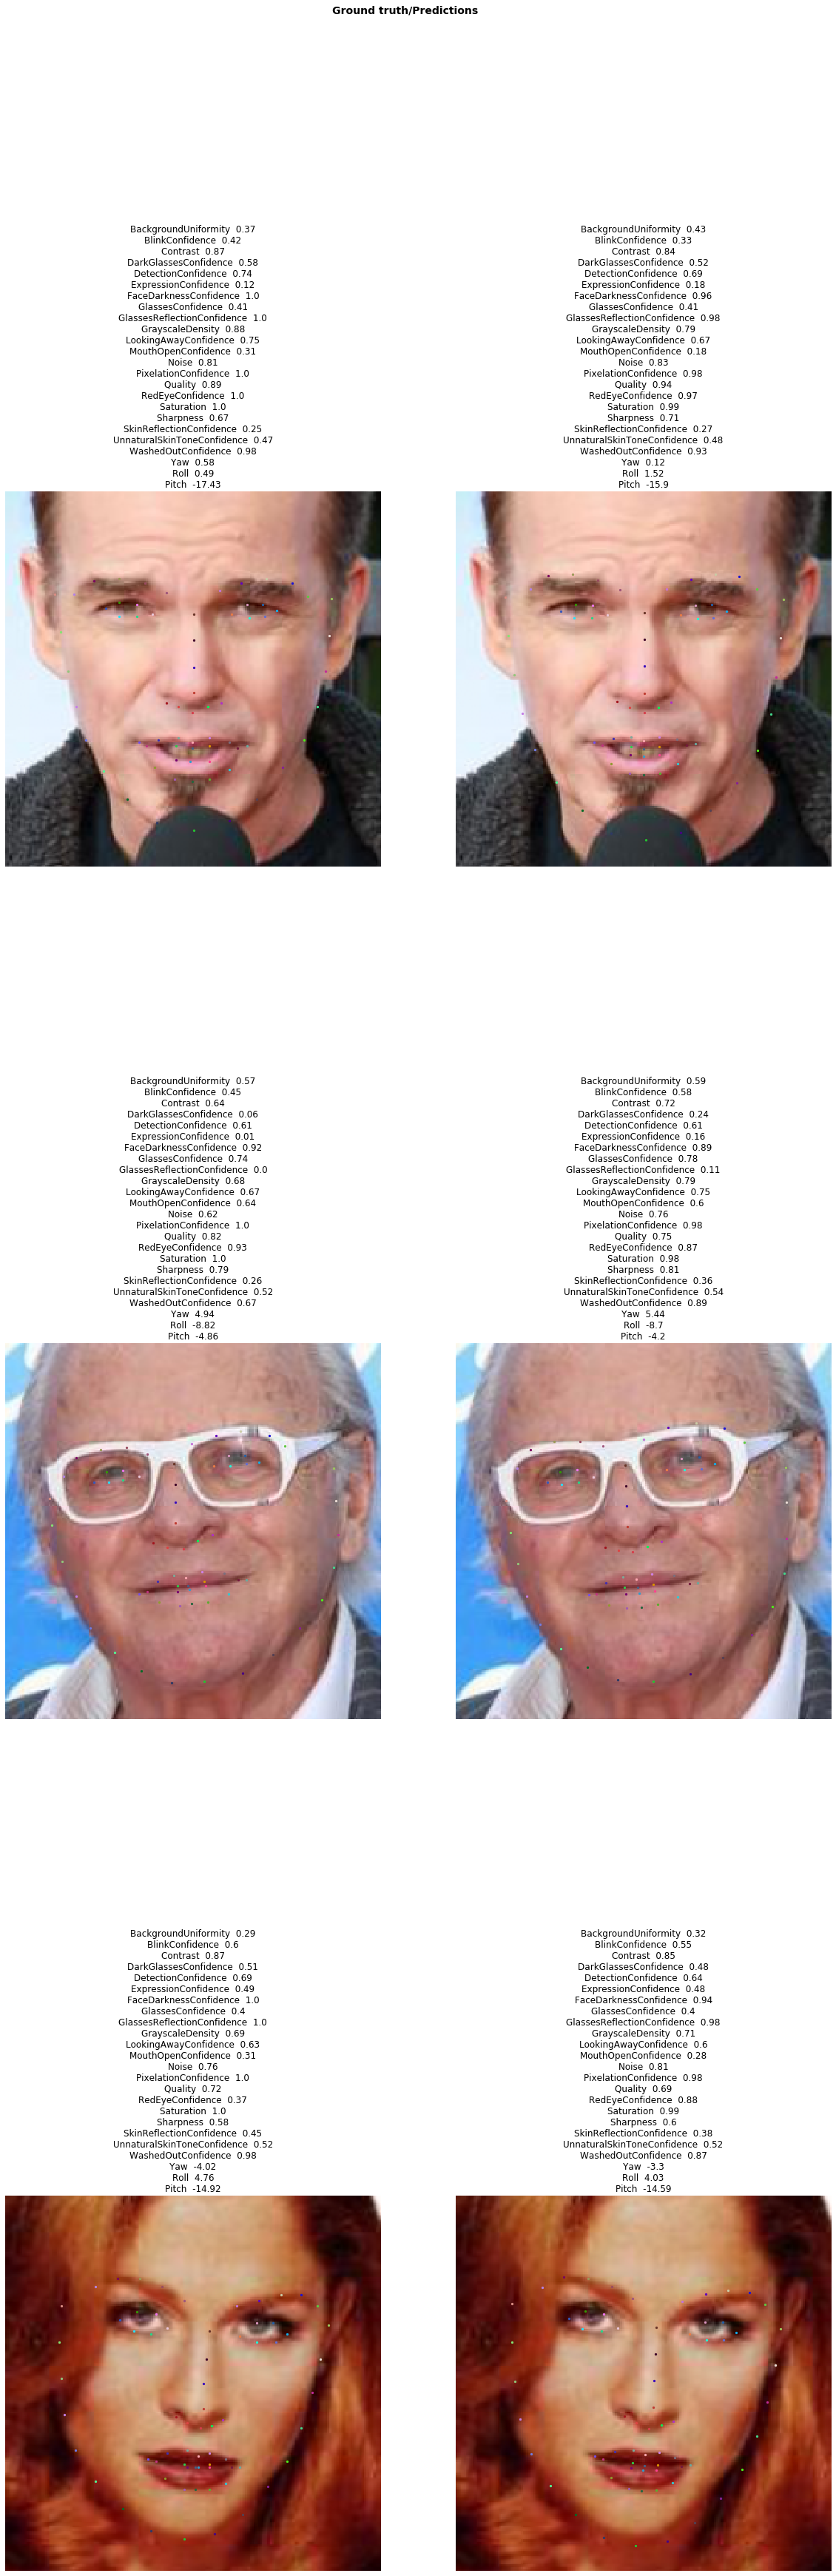

In [47]:
show_results(learner, DatasetType.Valid, rows=3)

In [48]:
save_torch_inference(learner.model, '../server/model.pth')

In [49]:
loss = CustomLossBinVisual(nn.SmoothL1Loss(), [1,1,1,1,1])
data = create_data(src, size, bs=64, transforms=None)
learner = create_learner(data, model, loss_func=loss, callback_fns=[ShowGraph, AddLossMetrics], metrics=[])
freeze_layers(learner, [])

Learner split in 5 groups


epoch,train_loss,valid_loss,Ldist,Lspatial,Lbin_BCE,Lbin_MSE,Lfloat,MBack,MBlin,MCont,MDark,MDete,MExpr,MFace,MGlas,MGlas,MGray,MLook,MMout,MNois,MPixe,MQual,MRedE,MSatu,MShar,MSkin,MUnna,MWash,time
0,0.025965,0.062918,0.019386,0.035441,0.000000,0.006552,0.001539,0.104370,0.078416,0.035152,0.045217,0.035374,0.070001,0.036854,0.080350,0.080350,0.046591,0.083859,0.067523,0.046607,0.032782,0.089090,0.039313,0.013473,0.050184,0.037704,0.020228,0.045242,02:51
1,0.075699,0.062172,0.019163,0.035148,0.000000,0.006562,0.001299,0.104625,0.077734,0.035401,0.045348,0.034491,0.070455,0.037750,0.086906,0.086906,0.045830,0.082201,0.065961,0.048035,0.032923,0.097680,0.041171,0.014704,0.054042,0.036675,0.018698,0.045465,02:53
2,0.047496,0.061516,0.019105,0.035094,0.000000,0.006139,0.001177,0.103519,0.074818,0.034742,0.044366,0.033600,0.067910,0.036007,0.085947,0.085947,0.047008,0.080248,0.065174,0.045161,0.032532,0.089086,0.037809,0.012488,0.048091,0.035166,0.018266,0.044223,02:53
3,0.077698,0.061025,0.019095,0.035063,0.000000,0.005774,0.001094,0.101545,0.073244,0.032569,0.042074,0.033016,0.061498,0.033471,0.074146,0.074146,0.043929,0.078638,0.062548,0.044600,0.032677,0.085741,0.035269,0.012243,0.048322,0.033296,0.017723,0.043097,02:53
4,0.038759,0.061016,0.019088,0.035058,0.000000,0.005743,0.001127,0.101592,0.073066,0.033177,0.042048,0.033078,0.061365,0.034069,0.072887,0.072887,0.043981,0.078984,0.061189,0.044285,0.032607,0.085278,0.035077,0.011146,0.047434,0.033873,0.017438,0.043352,02:53


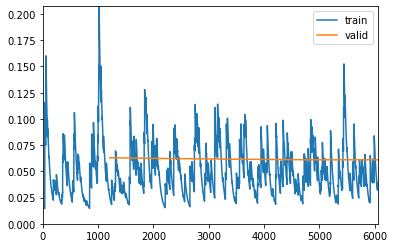

In [50]:
learner.fit_one_cycle(5, 1e-4)

In [51]:
save_torch_inference(learner.model, '../server/model.pth')

# Example

In [78]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [67]:
from facelib.core import plot

In [68]:
MODEL = model.to('cpu')

In [100]:
import cv2

In [ ]:
im = cv2.imread('../test_data/Face629.jpg')
im = im[ 50:260 , 30:210 ]
im = im[:,:,[2,1,0]] # cv2.circle doesnt like this :(
h,w,c = im.shape

fpts, bins, floats = MODEL(tensor(im[:,:,[2,1,0]]).permute(2,0,1)[None] / 255.)
fpts, bins, floats = map(lambda x:x[0], [fpts, bins, floats])
fpts = (fpts+1)/2 * torch.tensor([h,w])[None]
fpts = [[int(y),int(x)] for y,x in fpts]
for y,x in fpts:
    im = cv2.circle(im, (x, y), radius=2, color=(255,0,0), thickness=1)
plot(im)